# Import 



In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from keras import optimizers, Sequential
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed,Dropout, Input
from keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.models import Model
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

LABELS = ["Normal", "Anomaly"]

# Import Functions

In [68]:

def temporalize(in_X, lb):
    X = []
    for i in range(lb, len(in_X)+1):
        X.append(in_X[i - lb:i, :])
    X = np.array(X)
    return X


def temporalize_test(in_X, in_y, in_cat, lb):
    X = []
    y = []
    y_cat =[]
    for i in range(lb, len(in_X) + 1):
        X.append(in_X[i - lb:i, :])
        y.append(in_y[i-1])
        y_cat.append(in_cat[i-1])
    X = np.array(X)
    y = np.array(y)
    y_cat = np.array(y_cat)
    return X, y, y_cat

def make_lookback(df_t, lb):
    X = []
    X = np.array(X)
    users = list(df_t.iloc[:, 0].unique())
    flag = 1
    for usr in users:
        udf = df_t[df_t.iloc[:, 0] == usr]
        input_X = udf.loc[:, ].values
        t1 = temporalize(input_X, lb)
        if flag == 1:
            X = t1
            flag = 0
        else:
            if t1.size != 0:
                X = np.concatenate([X, t1])
    return X


def make_lookback_test(df_t, lb):
    X = []
    X = np.array(X)
    Y = []
    Y = np.array(Y)
    users = list(df_t.iloc[:, 0].unique())
    flag = 1
    for usr in users:
        udf = df_t[df_t.iloc[:, 0] == usr]
        y = udf.iloc[:, -1].values
        input_X = udf.iloc[:, :-1].values
        t1, t2 = temporalize_test(input_X, y, lb)
        if flag == 1:
            X = t1
            Y = t2
            flag = 0
        else:
            if t1.size != 0:
                X = np.concatenate([X, t1])
                Y = np.concatenate([Y, t2])
    return X, Y
def flatten_data(X):
    lb = X.shape[1]
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, lb-1, :]
    return flattened_X
def prepare_test_data(traindata, testdata):
    lb = traindata.shape[1]
    y = traindata[:, 0]
    y = list(y.T)
    z = list(y[0])
    l = len(z)
    test_X = np.zeros((len(testdata), lb, traindata.shape[2]))
    flag = 0
    for item in testdata:
        idx = l - 1 - z[::-1].index(item[0])
        test_X[flag, 0:lb-1, ] = traindata[idx, 1:, ]
        test_X[flag, lb-1:, ] = testdata[flag]
        flag += 1
        print(flag)
    return test_X
def read_data(path):
    df1 = pd.read_csv(path)
    df1 = df1.drop(['start_ts','session_duration'], axis=1)
    df1 = df1.fillna(0)
    # df1.insert(loc=1, column='u', value=df1['user'].values)
    df1['role'] = df1['role'].astype('category')
    df1['role'] = df1['role'].cat.codes
    df1['user'] = df1['user'].astype('category')
    df1['user'] = df1['user'].cat.codes

    # df1['u'] = df1['u'].astype('category')
    # df1['u'] = df1['u'].cat.codes
    # ce_ord = ce.BinaryEncoder(cols=['u'])
    # df1 = ce_ord.fit_transform(df1)

    return df1

def arrange_data(array_np):
    X = array_np
    new_array = np.zeros((X.shape[0], X.shape[1], X.shape[2]))
    y = X[:, 0]
    y = list(y.T)
    z = list(y[0])
    all_items = np.array(z)
    z = list(dict.fromkeys(z))
    flag = 0
    length = len(X)
    while length != 0:
        ind = []
        for user in z:
            if user in all_items:
                i = all_items.tolist().index(user)
                new_array[flag] = X[i]
                ind.append(i)
                print(flag)
                flag += 1
        X = np.delete(X, ind, axis=0)
        all_items = np.delete(all_items, ind)
        length = len(X)
    return new_array

In [69]:
#make this global
sc = MinMaxScaler(feature_range=(0, 1))

# Get train, valid and test data

In [70]:
def get_train_valid_test_data(train, valid, test, lb):
    X_train = []
    X_train = np.array(X_train)
    X_valid = []
    X_valid = np.array(X_train)
    X_test = []
    X_test = np.array(X_train)
    y_test = []
    y_test = np.array(y_test)
    
    users = list(train.user.unique())
    flag = 1
    for usr in users:
        u_train = train.loc[train['user'] == usr]
        u_valid = valid.loc[valid['user'] == usr]
        u_test = test.loc[test['user'] == usr]
        u_y_test = u_test['class'].values
        u_test = u_test.drop(['class'], axis=1)
        
        sc = MinMaxScaler(feature_range=(0, 1))
        u_train = sc.fit_transform(u_train)
        u_valid = sc.transform(u_valid)
        u_test = sc.transform(u_test)
        
        t1 = temporalize(u_train, lb)
        t2 = temporalize(u_valid, lb)
        t3, t4 = temporalize_test(u_test, u_y_test, lb)
        
        if flag == 1:
            X_train = t1
            X_valid = t2
            X_test = t3
            y_test = t4
            flag = 0
        else:
            if t1.size != 0:
                X_train = np.concatenate([X_train, t1])
            if t2.size != 0:
                X_valid = np.concatenate([X_valid, t2])
            if t3.size != 0:
                X_test = np.concatenate([X_test, t3])
            if t4.size != 0:
                y_test = np.concatenate([y_test, t4])
    return X_train, X_valid, X_test, y_test


# Get train, test data

In [71]:
def get_train_test_data(train, test, lb):
    X_train = []
    X_train = np.array(X_train)
    X_test = []
    X_test = np.array(X_train)
    y_test = []
    y_test = np.array(y_test)

    y_type = []
    y_type = np.array(y_type)

    users = list(train.user.unique())
    flag = 1
    for usr in users:
        u_train = train.loc[train['user'] == usr]
        u_test = test.loc[test['user'] == usr]
        u_y_test = u_test['class'].values
        u_y_cat = u_test['type'].values
        u_test = u_test.drop(['class','type'], axis=1)
        
        sc = MinMaxScaler(feature_range=(0, 1))
        u_train = sc.fit_transform(u_train)
        u_test = sc.transform(u_test)
        
        t1 = temporalize(u_train, lb)
        t3, t4, t5 = temporalize_test(u_test, u_y_test, u_y_cat, lb)
        
        if flag == 1:
            X_train = t1
            X_test = t3
            y_test = t4
            y_type = t5
            flag = 0
        else:
            if t1.size != 0:
                X_train = np.concatenate([X_train, t1])
            if t3.size != 0:
                X_test = np.concatenate([X_test, t3])
            if t4.size != 0:
                y_test = np.concatenate([y_test, t4])
                y_type = np.concatenate([y_type, t5])
    return X_train, X_test, y_test, y_type

# Import Drive

# Prepare Data

In [82]:
LABELS = ["Normal", "Anomaly"]
train_percent = 242043
test_percent = 0.2
validation_percent = 276388
lookback = 3
df = read_data("/home/sathish/UEBA/data/data.csv")

# # train, test = train_test_split(df, test_size=test_percent, shuffle=False)
train_data = df[0:validation_percent]
#valid_data = df[train_percent:validation_percent]
test_data = df[validation_percent:]

train_data = train_data.drop(['class','type'], axis=1)
# valid_data = valid_data.drop(['class'], axis=1)
X_train, X_test, y_test, y_category = get_train_test_data(train_data, test_data, lookback)
X_train = X_train[:, :, 1:]
X_test = X_test[:, :, 1:]

# Model

In [ ]:
import os
n_features = X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
#X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

epochs = 100
batch = 256
lr = 0.0001
timesteps = lookback
encoding_dim = 16
hidden_dim = 8
# Define model
# Define model save path
model_path = "lstm_autoencoder.h5"

if os.path.exists(model_path):
    print("Loading existing model...")
    from tensorflow.keras.losses import MeanSquaredError
    lstm_model = load_model(model_path, custom_objects={'MeanSquaredError': MeanSquaredError()})
    cp = ModelCheckpoint(filepath="ae_classifier.h5",
                        save_best_only=True,
                        verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)
else:
    inputs = Input(shape = (timesteps, n_features))
    L1 = LSTM(encoding_dim, activation ='relu', return_sequences=True, 
            kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = LSTM(hidden_dim, activation='relu', return_sequences=False)(L1)
    L3 = RepeatVector(timesteps)(L2)
    L4 = LSTM(hidden_dim, activation='relu', return_sequences=True)(L3)
    L5 = LSTM(encoding_dim, activation='relu', return_sequences=True)(L4)
    output = TimeDistributed(Dense(n_features))(L5)
    lstm_model = Model(inputs=inputs, outputs=output)
    lstm_model.summary()

    adam = optimizers.Adam(lr)
    lstm_model.compile(loss='MeanSquaredError', optimizer=adam)


    cp = ModelCheckpoint(filepath="ae_classifier.h5",
                        save_best_only=True,
                        verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)
    es = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience = 2)
    lstm_model_history = lstm_model.fit(X_train, X_train,
                                        epochs=epochs,
                                        batch_size=batch,
                                        shuffle=False,
                                        verbose=1,
                                        validation_split=0.12,
                                        callbacks=[es, cp, tb]).history
    # Save trained model
    lstm_model.save(model_path)






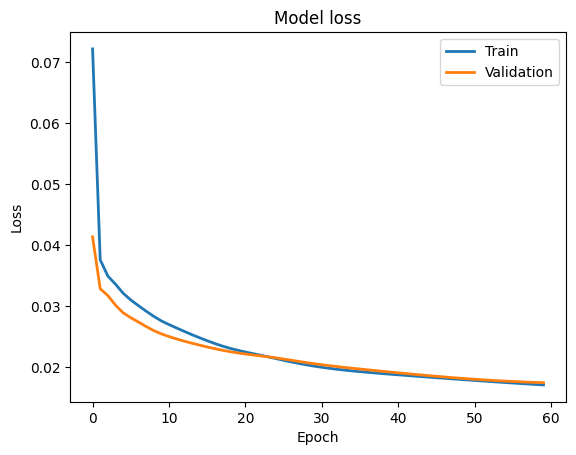

[0.07213324308395386, 0.03756299242377281, 0.03489350527524948, 0.03356670215725899, 0.03207977116107941, 0.030974434688687325, 0.0300437118858099, 0.029142461717128754, 0.028299041092395782, 0.027544721961021423, 0.02694018930196762, 0.026380643248558044, 0.02582329325377941, 0.025286076590418816, 0.024780550971627235, 0.024291841313242912, 0.023831460624933243, 0.02341616339981556, 0.023048069328069687, 0.022727489471435547, 0.02244265004992485, 0.02217644639313221, 0.021913642063736916, 0.02164332941174507, 0.02136460319161415, 0.02108612097799778, 0.020818961784243584, 0.02056899107992649, 0.020338794216513634, 0.020128687843680382, 0.01993861049413681, 0.019767306745052338, 0.019612951204180717, 0.019472753629088402, 0.019344110041856766, 0.019224435091018677, 0.019111448898911476, 0.01900358311831951, 0.01890007220208645, 0.018799856305122375, 0.01870216242969036, 0.01860642246901989, 0.018512148410081863, 0.018418865278363228, 0.01832633651793003, 0.018234219402074814, 0.0181428

In [86]:
plt.plot(lstm_model_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_model_history['val_loss'], linewidth=2, label='Validation')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
print(lstm_model_history['loss'])

# Results

In [87]:
tb.set_model(lstm_model)
test_x_predictions = lstm_model.predict(X_test)

1983/1983 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


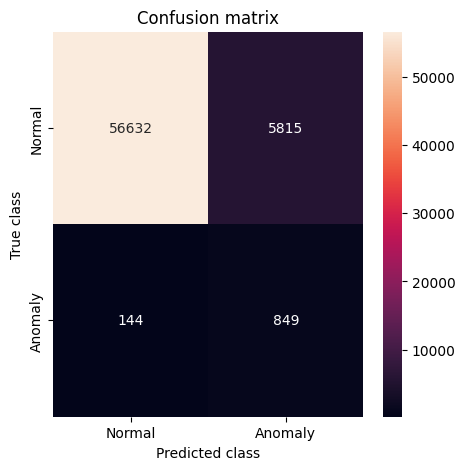

Text(0.5, 0, 'False Positive Rate')

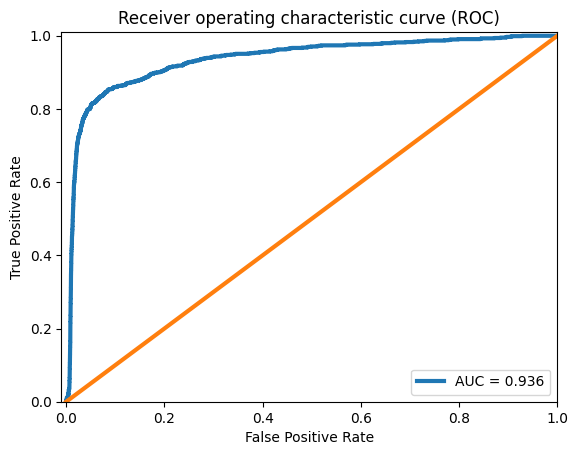

In [88]:
mse = np.mean(np.power(flatten_data(X_test) - flatten_data(test_x_predictions), 2), axis=1)

error_df = pd.DataFrame({'Reconstruction_error': mse,
                         'True_class': y_test})

# threshold = error_df.Reconstruction_error.mean()
threshold = 0.04
# output reconstruction error to file
# np.savetxt(out_prediction_file, error_df, delimiter=",")
# Confusion Matrix
pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# #  Plot predicted values
# groups = error_df.groupby('True_class')
# fig, ax = plt.subplots()

# for name, group in groups:
#     ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='')
# ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
# ax.legend()
# plt.title("Reconstruction error for different classes")
# plt.ylabel("Reconstruction error")
# plt.xlabel("Data point index")
# plt.show()

# AUC Plot
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate, )

plt.plot(false_pos_rate, true_pos_rate, linewidth=3, label='AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1], linewidth=3)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [89]:
import tensorflow as tf
import numpy as np

In [90]:


def generate_counterfactual(model, sequence, scaler, feature_names, learning_rate=0.01, iterations=500, immutable_features=[]):
    """
    Generates a counterfactual sequence by modifying input features to reduce reconstruction error.
    
    Args:
        model: Trained LSTM autoencoder.
        sequence: Anomalous sequence (numpy array, shape=(1, timesteps, features)).
        scaler: Scaler used for normalization (to inverse transform after modification).
        feature_names: List of feature names corresponding to the sequence.
        learning_rate: Step size for gradient updates.
        iterations: Number of optimization steps.
        immutable_features: List of feature names that should not change.

    Returns:
        Counterfactual sequence as a Pandas DataFrame.
    """

    # Convert sequence to a TensorFlow Variable (enables gradient tracking)
    sequence = tf.Variable(sequence, dtype=tf.float32)

    # Get indices of immutable features
    feature_indices = np.array([feature_names.index(feature) for feature in immutable_features if feature in feature_names])

    # Define optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(sequence)
            reconstruction = model(sequence)  # Get reconstructed output
            loss = tf.reduce_mean(tf.abs(reconstruction - sequence))  # Compute reconstruction error

        # Compute gradients
        grads = tape.gradient(loss, sequence)

        # Apply mask to prevent updates on immutable features
        grads = grads.numpy()
        if len(feature_indices) > 0:
            grads[:, :, feature_indices] = 0  # Prevent modification of immutable features
        grads = tf.convert_to_tensor(grads)

        # Apply gradient update
        optimizer.apply_gradients([(grads, sequence)])

    # Convert back to NumPy array and inverse transform
    counterfactual = sequence.numpy()

    # Select only the last time step for inverse transform
    counterfactual_last_step = counterfactual[:, -1, :]

    # Apply inverse transformation to bring back original scale
    counterfactual_last_step = scaler.inverse_transform(counterfactual_last_step)

    return pd.DataFrame(counterfactual_last_step, columns=feature_names)


In [91]:
type(pred_y)
pred_y1 = np.array(pred_y)
np.where(pred_y1== 1)
list(X_train.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [145]:
## **🚀 Example Call: Generating a Counterfactual for an Anomalous Sequence**

# Load trained LSTM autoencoder
from tensorflow.keras.models import load_model
scaler = sc
trainer = train_data.copy()
trainer = trainer.iloc[:,1:]
scaler.fit_transform(trainer)
if os.path.exists(model_path):
    print("Loading existing model...")
    from tensorflow.keras.losses import MeanSquaredError
    lstm_model = load_model(model_path, custom_objects={'MeanSquaredError': MeanSquaredError()})

# Define feature names separately (ensure you store them before converting to NumPy)
feature_names = [ "user","logon_on_own_pc_normal", "logon_on_other_pc_normal", 
                 "logon_on_own_pc_off_hour", "logon_on_other_pc_off_hour", 
                 "logon_hour", "day_of_a_week", "device_connects_on_own_pc",
                 "device_connects_on_other_pc", "device_connects_on_own_pc_off_hour",
                 "device_connects_on_other_pc_off_hour", "documents_copy_own_pc",
                 "documents_copy_other_pc", "exe_files_copy_own_pc", "exe_files_copy_other_pc",
                 "documents_copy_own_pc_off_hour", "documents_copy_other_pc_off_hour",
                 "exe_files_copy_own_pc_off_hour", "exe_files_copy_other_pc_off_hour",
                 "neutral_sites", "job_search", "hacking_sites", "neutral_sites_off_hour",
                 "job_search_off_hour", "hacking_sites_off_hour", "total_emails", "int_to_int_mails",
                 "int_to_out_mails", "out_to_int_mails", "out_to_out_mails",
                 "internal_recipients", "external_recipients", "distinct_bcc",
                 "mails_with_attachments", "after_hour_mails", "role",
                 "business_unit", "functional_unit", "department", "team", "O", "C", "E", "A", "N"]

# Select an anomalous instance
anomaly_idx = np.where(pred_y1 == 1)[0][0]  # First detected anomaly

# Ensure input has the correct shape for LSTM (sequence length = timesteps)
timesteps = 3  # Lookback period used during training

# Extract the sequence of length `timesteps` ending at `anomaly_idx`
if anomaly_idx >= timesteps:
    anomalous_sequence = flatten_data(X_test[anomaly_idx - timesteps:anomaly_idx]).reshape(1, timesteps, -1)
else:
    raise ValueError(f"Anomaly index {anomaly_idx} is too small for timesteps={timesteps}.")

# List of immutable features (e.g., user ID should not change)
immutable_features = ["user"]

# Call the counterfactual generator
counterfactual_example = generate_counterfactual(
    lstm_model, anomalous_sequence, scaler, feature_names, immutable_features=immutable_features
)

# Print the counterfactual sequence
print("\nCounterfactual Example (with 'user' constant):")
print(counterfactual_example)


Loading existing model...


ValueError: Shape of passed values is (1, 44), indices imply (1, 45)

In [142]:
len(feature_names)


45

In [114]:
print(train_data.columns.size)
print(X_train[0][0].size)
print(train_data.columns)


45
44
Index(['user', 'logon_on_own_pc_normal', 'logon_on_other_pc_normal',
       'logon_on_own_pc_off_hour', 'logon_on_other_pc_off_hour', 'logon_hour',
       'day_of_a_week', 'device_connects_on_own_pc',
       'device_connects_on_other_pc', 'device_connects_on_own_pc_off_hour',
       'device_connects_on_other_pc_off_hour', 'documents_copy_own_pc',
       'documents_copy_other_pc', 'exe_files_copy_own_pc',
       'exe_files_copy_other_pc', 'documents_copy_own_pc_off_hour',
       'documents_copy_other_pc_off_hour', 'exe_files_copy_own_pc_off_hour',
       'exe_files_copy_other_pc_off_hour', 'neutral_sites', 'job_search',
       'hacking_sites', 'neutral_sites_off_hour', 'job_search_off_hour',
       'hacking_sites_off_hour', 'total_emails', 'int_to_int_mails',
       'int_to_out_mails', 'out_to_int_mails', 'out_to_out_mails',
       'internal_recipients', 'external_recipients', 'distinct_bcc',
       'mails_with_attachments', 'after_hour_mails', 'role', 'business_unit',
       'fun

In [63]:
# Select an anomalous instance
anomaly_idx = np.where(pred_y1 == 1)[0][0]  # First detected anomaly
print(anomaly_idx)
anomalous_sequence = flatten_data(X_test[anomaly_idx - timesteps:anomaly_idx])
print(anomalous_sequence.reshape(1, timesteps, -1))

4
[[[1.         0.         0.5        0.         0.26086957 0.33333333
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.83333333 0.         0.         0.42857143 0.         0.
   1.         1.         0.         0.         0.         0.5
   0.         0.5        0.14285714 0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [1.         0.         0.5        0.         0.30434783 0.5
   0.5        0.         0.         0.         0.125      0.
   0.         0.         0.         0.         0.         0.
   0.91111111 0.         0.         0.22857143 0.         0.
   1.         0.33333333 0.         0.         0.66666667 0.4
   0.45454545 1.         0.28571429 0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [1.         0.         0.5        0.         0.30434783 0.66666667
   0.5      

In [49]:
print(lstm_model.input_shape)  # Should print: (None, 3, 44)
print("Anomalous sequence shape:", anomalous_sequence.shape)
print("X_train",X_train.shape)


(None, 3, 44)
Anomalous sequence shape: (1, 3, 132)
X_train (274388, 3, 44)


In [25]:
anomalous_sequence

array([[[ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]])

In [1]:
import numpy as np

# Simulated X_test dataset (6 samples, 4 features each)
X_test = np.array([
    [0, 1, 2, 3],  # Index 0
    [4, 5, 6, 7],  # Index 1
    [8, 9, 10, 11],  # Index 2
    [12, 13, 14, 15],  # Index 3
    [16, 17, 18, 19],  # Index 4
    [20, 21, 22, 23]   # Index 5
])

# Anomaly detected at index 4
anomaly_idx = 4

# Lookback timesteps
timesteps = 3

# Extract the sequence
anomalous_sequence = X_test[anomaly_idx - timesteps:anomaly_idx]

print("Extracted Sequence (Last 3 timesteps before anomaly):")
print(anomalous_sequence)
#3x1 



Extracted Sequence (Last 3 timesteps before anomaly):
[[ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


In [23]:
anomalous_sequence.shape

(1, 3, 4)

In [20]:
num_features = X_test.shape[1] 

In [22]:
anomalous_sequence = anomalous_sequence.reshape(1, timesteps, num_features)

In [24]:
anomalous_sequence

array([[[ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [12, 13, 14, 15]]])

In [ ]:
# Select an anomalous instance
anomaly_idx = np.where(pred_y1== 1)[0][0]  # First detected anomaly

# Ensure input has the correct shape for LSTM (sequence length = timesteps)
timesteps = 3  # Lookback period used during training
num_features = 44  # Ensure this matches the LSTM model's expected input feature count

# Extract the sequence of length `timesteps` ending at `anomaly_idx`
if anomaly_idx >= timesteps:
    anomalous_sequence = X_test[anomaly_idx - timesteps:anomaly_idx]  # Select a sequence of 3 rows

    print("Anomalous sequence shape before reshaping:", anomalous_sequence.shape)
    # Correctly reshape to (1, timesteps, num_features) instead of (1, timesteps, timesteps*num_features)
    anomalous_sequence = anomalous_sequence.reshape(1, timesteps, num_features)

else:
    raise ValueError(f"Anomaly index {anomaly_idx} is too small for timesteps={timesteps}.")

print("Corrected anomalous sequence shape:", anomalous_sequence.shape)  # Should print (1, 3, 44)


# Curve Plots



In [17]:
threshold = 0.02
increment = 0.001
stopping = 0.06
th = []
prec = []
rec = []
accuracy = []
f1 = []
TPR = []
FPR = []
TNR = []
while threshold < stopping:
  pred_y = [1 if e > threshold else 0 for e in error_df.Reconstruction_error.values]
  conf_matrix = confusion_matrix(error_df.True_class, pred_y)
  TP = conf_matrix[1][1]
  FP = conf_matrix[0][1]
  TN = conf_matrix[0][0]
  FN = conf_matrix[1][0]
  th.append(threshold)
  p = TP/(TP+FP)
  r = TP/(TP+FN)
  prec.append(p)
  rec.append(r)
  accuracy.append((TN+TP)/(TN+TP+FN+FP))
  TPR.append(TP/(TP+FN))
  FPR.append(FP/(TN+FP))
  TNR.append(TN/(TN+FP))
  f1.append(2*p*r/(p+r))
  threshold = threshold + increment


# Precision vs Recall

In [ ]:
plt.plot(th, prec, linewidth=2, label='Precision', color ='r')
plt.plot(th, rec, linewidth=2, label='Recall', color='b')
plt.title('Precision/Recall Curve')
plt.ylabel('Precision/Recall')
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.show()


# **Accuracy Plot**

In [ ]:
plt.plot(th, accuracy, linewidth=2, label='Accuracy', color ='r')
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.legend(loc='lower right')
plt.show()

**F1 Score Plot**

In [ ]:
plt.plot(th, f1, linewidth=2, label='F1 Score', color ='r')
plt.title('F1 Score Plot')
plt.ylabel('F1 Score')
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.show()

**TPR vs TNR**

In [ ]:
plt.plot(th, TPR, linewidth=2, label='TPR', color ='r')
plt.plot(th, TNR, linewidth=2, label='TNR', color='b')
plt.title('TPR, TNR Curve')
plt.ylabel('TPR/TNR')
plt.xlabel('Threshold')
plt.legend(loc='upper right')
plt.show()